Compare to [R solution](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).

First read in data

In [1]:
import pandas

dir = "../../PracticalDataScienceWithR2nd/PDSwR2/KDD2009/"
d = pandas.read_csv(dir + 'orange_small_train.data.gz', sep='\t', header=0)
vars = [c for c in d.columns]
d.shape

(50000, 230)

In [2]:
churn = pandas.read_csv(dir + 'orange_small_train_churn.labels.txt', header=None)
churn.columns = ["churn"]
churn.shape

(50000, 1)

In [3]:
churn["churn"].value_counts()

-1    46328
 1     3672
Name: churn, dtype: int64

arrange test/train split

In [4]:
import numpy.random

n = d.shape[0]
is_train = numpy.random.uniform(size=n)<=0.9
is_test = numpy.logical_not(is_train)

In [5]:
d_train = d.loc[is_train, :].copy()
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"]==1)
d_test = d.loc[is_test, :].copy()
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"]==1)

Treat variables

In [6]:
import vtreat

In [7]:
plan = vtreat.binomial_outcome_treatment(outcomename="y", outcometarget=True)

In [8]:
cross_frame = plan.fit_transform(d_train, churn_train)

In [9]:
sf = plan.score_frame_
sf.head()

,variable,treatment,y_aware,PearsonR,significance,vcount,recommended
0,Var1_is_bad,missing_indicator,False,0.001885,0.688921,193.0,False
1,Var2_is_bad,missing_indicator,False,0.018179,0.000113,193.0,True
2,Var3_is_bad,missing_indicator,False,0.018146,0.000116,193.0,True
3,Var4_is_bad,missing_indicator,False,0.018424,0.000091,193.0,True
4,Var5_is_bad,missing_indicator,False,0.018589,0.000079,193.0,True


In [10]:
sf.shape

(519, 7)

In [11]:
sf.loc[sf["y_aware"], :]

,variable,treatment,y_aware,PearsonR,significance,vcount,recommended
366,Var191_logit_code,logit_code,True,-0.010852,0.021195,38.0,False
369,Var192_logit_code,logit_code,True,-0.004734,0.314785,38.0,False
371,Var193_logit_code,logit_code,True,0.001687,0.720204,38.0,False
375,Var194_logit_code,logit_code,True,-0.007852,0.095460,38.0,False
379,Var195_logit_code,logit_code,True,0.003428,0.466701,38.0,False
382,Var196_logit_code,logit_code,True,-0.005286,0.261701,38.0,False
385,Var197_logit_code,logit_code,True,-0.001359,0.772894,38.0,False
392,Var198_logit_code,logit_code,True,-0.001283,0.785333,38.0,False
395,Var199_logit_code,logit_code,True,0.003023,0.520901,38.0,False
397,Var200_logit_code,logit_code,True,-0.003642,0.439325,38.0,False


In [12]:
sf.loc[numpy.logical_and(sf["recommended"],sf["y_aware"]), :]

,variable,treatment,y_aware,PearsonR,significance,vcount,recommended


In [13]:
model_vars = numpy.asarray(sf["variable"][sf["recommended"]])
len(model_vars)

231

In [14]:
cross_frame.head()

,Var1_is_bad,Var2_is_bad,Var3_is_bad,Var4_is_bad,Var5_is_bad,Var6_is_bad,Var7_is_bad,Var9_is_bad,Var10_is_bad,Var11_is_bad,...,Var228_logit_code,Var228_prevalence_code,Var228_lev_F2FyR07IdsN7I,Var228_lev_55YFVY9,Var228_lev_ib5G6X1eUxUn6,Var229_logit_code,Var229_prevalence_code,Var229_lev__NA_,Var229_lev_am7c,Var229_lev_mj86
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.007700,0.654403,1,0,0,-0.009832,0.568270,1,0,0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.010584,0.654403,1,0,0,-0.003556,0.568270,1,0,0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.076126,0.053534,0,0,1,0.022498,0.234715,0,1,0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,-0.104512,0.654403,1,0,0,-0.007813,0.195396,0,0,1
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.010584,0.018517,0,0,0,0.004001,0.234715,0,1,0


In [15]:
import xgboost

In [16]:

fd = xgboost.DMatrix(data=cross_frame.loc[:, model_vars], label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [17]:
cv.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.073238,0.001498,0.073914,0.003063
1,0.073404,0.001476,0.073404,0.002952
2,0.073382,0.001463,0.073404,0.002952
3,0.073404,0.001476,0.073404,0.002952
4,0.073415,0.001460,0.073404,0.002952


In [18]:
best = cv.loc[cv["test-error-mean"]<= min(cv["test-error-mean"] + 1.0e-9), :]
best



,train-error-mean,train-error-std,test-error-mean,test-error-std
42,0.071763,0.001751,0.072894,0.002462
49,0.071386,0.001583,0.072894,0.002368
50,0.071408,0.001580,0.072894,0.002368


In [19]:
ntree = best.index.values[0]
ntree

42

In [20]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=42,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [21]:
model = fitter.fit(cross_frame.loc[:, model_vars], churn_train)




In [22]:
test_processed = plan.transform(d_test)

In [23]:

pf = pandas.DataFrame({"churn":churn_test})
preds = model.predict_proba(test_processed.loc[:, model_vars])



In [24]:
pf["pred"] = preds[:, 1]

In [25]:
import wvpy.util

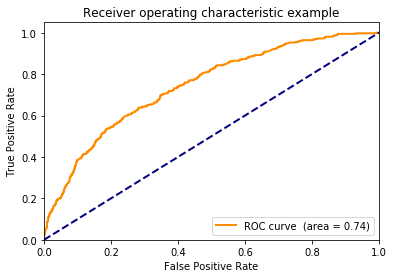

0.7429389347774557

In [26]:
wvpy.util.plot_roc(pf["pred"], pf["churn"])